In [1]:
using Pkg
using Revise
Pkg.activate("./scripts/julia_modules/JuliaClusterAndTreeTools")
using JuliaClusterAndTreeTools
using Statistics
using Pkg
using RCall
using DataFrames
using StatsBase
using CSV
R"""
library(ggplot2)
library(fitdistrplus)
library(patchwork)
library(fitdistrplus)
library(data.table)

"""



  Activating project at `./scripts/julia_modules/JuliaClusterAndTreeTools`


┌ Warning: RCall.jl: Loading required package: MASS
│ Loading required package: survival
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172
┌ Warning: RCall.jl: 
│ Attaching package: ‘patchwork’
│ 
│ The following object is masked from ‘package:MASS’:
│ 
│     area
│ 
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


RObject{StrSxp}
 [1] "data.table"   "patchwork"    "fitdistrplus" "survival"     "MASS"        
 [6] "ggplot2"      "stats"        "graphics"     "grDevices"    "utils"       
[11] "datasets"     "methods"      "base"        


In [2]:
in_file_name = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000.fasta.gz"
output_file_name = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_filtered.fasta.gz"
output_file_nonconspoz_name = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_filtered_nonconspoz.fasta.gz"
rows_after_filter = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_kept_rows.txt"
columns_after_filter = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_kept_columns.txt"
conservation_data =  "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_data.csv"

keepPositionsFraction = 0.8
topNhaving_sequences_to_remove = 10
reference_seq_id = "England/ALDP-3C3EB7C/2022"
country = "England"

"England"

In [3]:
# Parameters
in_file_name = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000.fasta.gz"
output_file_name = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_filteredsmall.fasta.gz"


"/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_filteredsmall.fasta.gz"

In [4]:
aln = JuliaClusterAndTreeTools.Alignment(in_file_name)
#aln = JuliaClusterAndTreeTools.Alignment("/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade.fasta.gz")
print("Alignment parsed")
initial_length = size(aln.M)[2]
reference_seq = collect(join(aln.M[aln.name_sequence_map[reference_seq_id],:]))
print("Initial length and reference sequence saved")

Reading aligment /mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000.fasta.gz



Alignment parsedInitial length and reference sequence saved

In [5]:
dc = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)
dr = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)
print("Initial statistics on gaps and N done")

Doing transposition...
Done. Converting to a data frame...


Done


Doing transposition...


Done. Converting to a data frame...


Initial statistics on gaps and N done

Initial distribution of gaps across the alignment


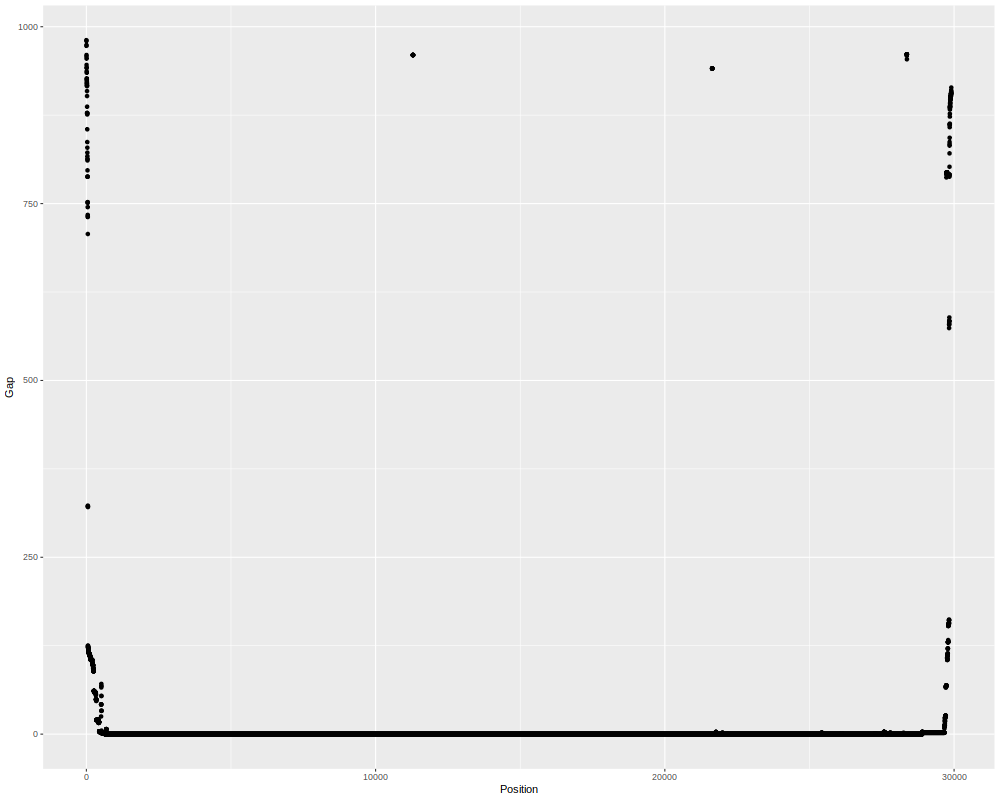

RObject{VecSxp}


In [6]:
@rput dc

println("Initial distribution of gaps across the alignment")
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
p <- ggplot(data=dc) + geom_point(aes(x=Position,y=Gap))
p
"""

In [7]:
blacklist_positions = Array{Int64,1}()
# array to keep column indices to be discarded

Int64[]

In [8]:
# remove tails down to first non zero
median_Gap = median(dc.Gap)
starti = undef
endi = undef
lenAln = size(dc)[1]
for i in  1:lenAln
    if dc.Gap[i] ==0
        starti = i
        break
    else
        push!(blacklist_positions,i)
    end
end

for i in  1:lenAln
    ie = lenAln-i+1
    if dc.Gap[ie] ==0
        endi = ie
        break
    else
        push!(blacklist_positions,ie)
    end
end
println("Non gapped alignment starts at this position: ",starti)
println("Gaps terminate alignment at this position",endi)
#JuliaClusterAndTreeTools.sub_alignment!(aln,starti:endi)

Non gapped alignment starts at this position: 645
Gaps terminate alignment at this position28893


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


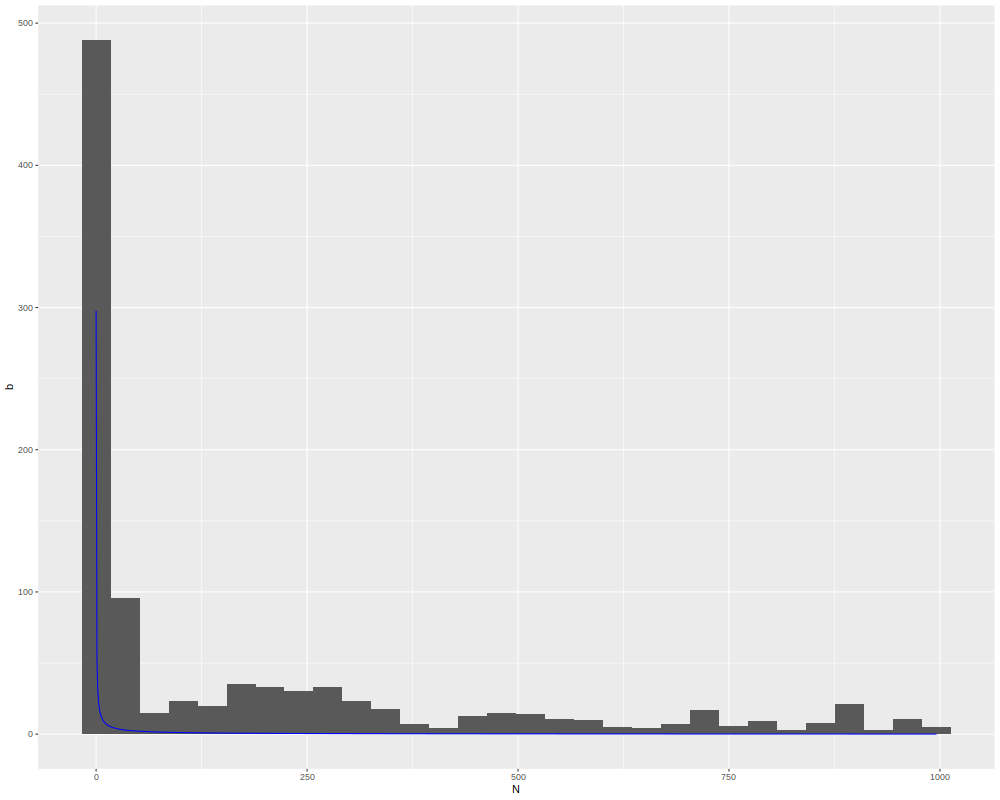

RObject{VecSxp}


In [9]:
@rput dr
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
fit <- fitdist(dr$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=dr) + geom_histogram(aes(x=N))
xvals <- dr$N
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(dr)
df = data.table(a=xvals,b=fitD)
p <- p + geom_line(data = df, aes(a,b),color="blue")
p
"""
# library(fitdistrplus)
# fit <- fitdist(dc$N, "nbinom")
# mu = as.double(fit$estimate["mu"][[1]])
# size = as.double(fit$estimate["size"][[1]])
# fitD <- dnbinom(0:60, size=size, mu=mu)

In [10]:
maxNlimit = percentile(dr.N,100-topNhaving_sequences_to_remove)
println("Sequences having N more than ",maxNlimit, " will be removed")
keep_ids = dr.ID[dr.N .< maxNlimit]
sub_alignment!(aln,keep_ids)
println("Alignment size after removal of top most N having sequences")
println(size(aln.M))
#println(maximum(dr.N))

Sequences having N more than 597.6000000000013

 will be removed


Alignment size after removal of top most N having sequences
(888, 29903)


In [11]:
println("Recalculatig data on N and Gaps per sequence - rowwise ")
dr = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)
print("")

Recalculatig data on N and Gaps per sequence - rowwise 


Doing transposition...


Done. Converting to a data frame...


replot dta on N rowwise


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


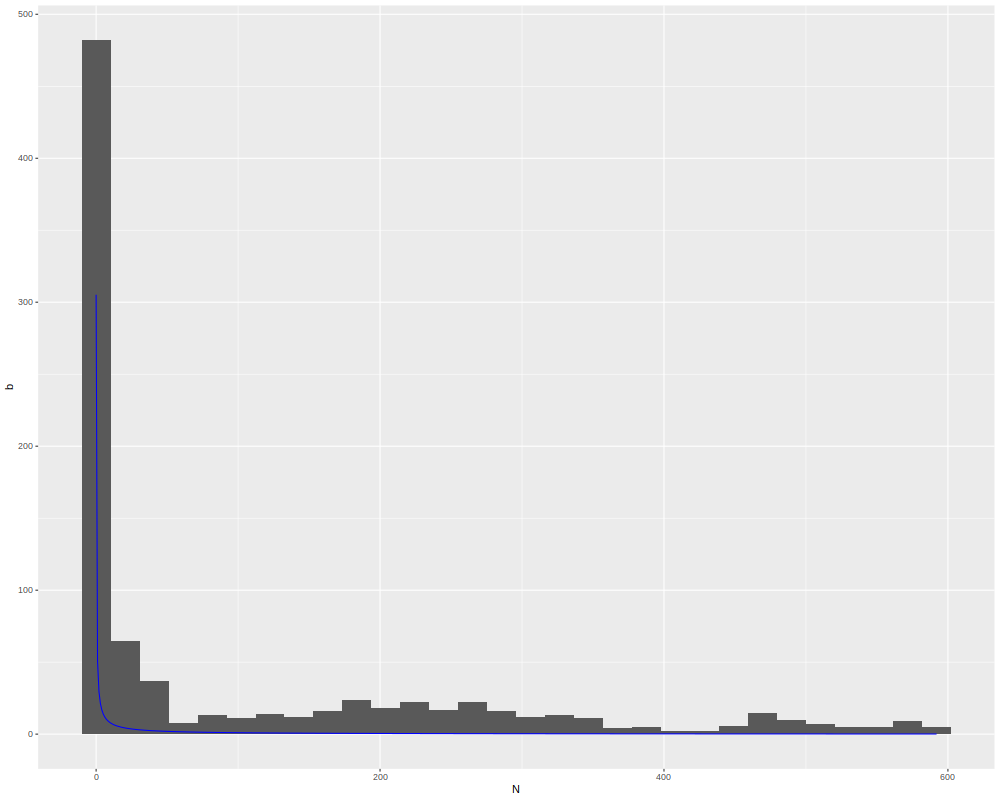

RObject{VecSxp}


In [12]:
println("replot dta on N rowwise")
@rput dr
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
fit <- fitdist(dr$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=dr) + geom_histogram(aes(x=N))
xvals <- dr$N
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(dr)
df = data.table(a=xvals,b=fitD)
p <- p + geom_line(data = df, aes(a,b),color="blue")
p
"""

In [13]:
println("Recalculating statistics on N columnwise")
dc = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)
print("")

Recalculating statistics on N columnwise


Doing transposition...
Done. Converting to a data frame...
Done


In [14]:
# get a subset of columns without terminal gaps
dc_woterminalgaps = filter(:Position => !in(blacklist_positions), dc)
print("")

Distribution of N across columns after removal of terminal gappy regions


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


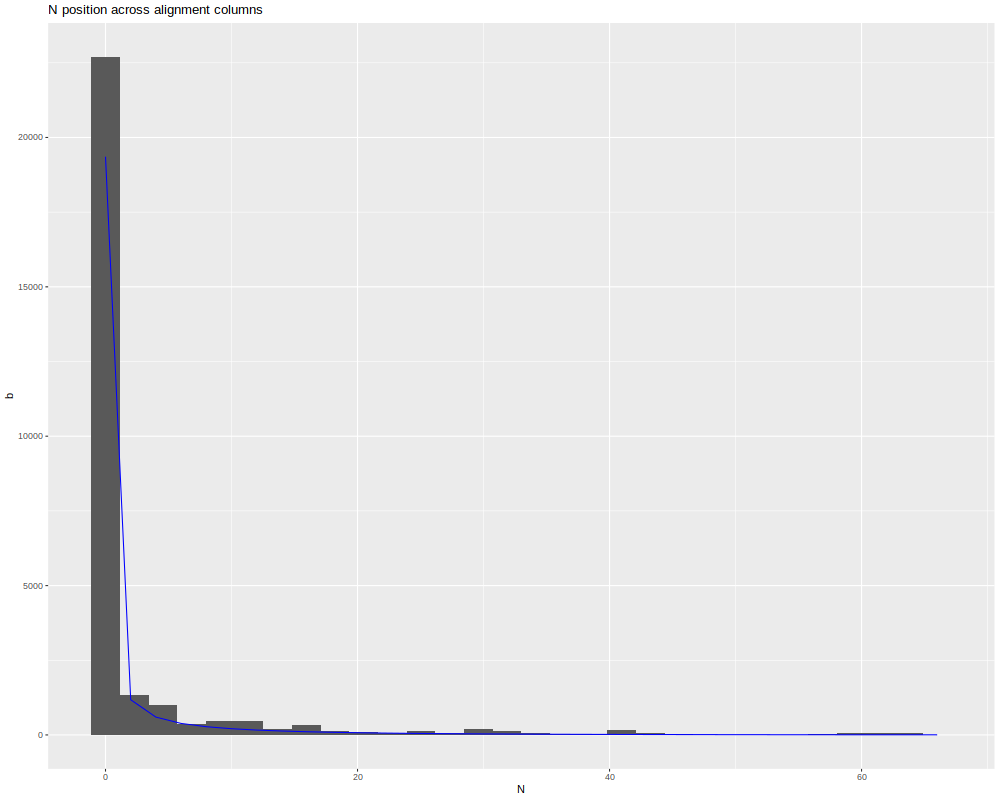

RObject{VecSxp}


In [15]:
println("Distribution of N across columns after removal of terminal gappy regions")
@rput dc_woterminalgaps
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
df <- dc_woterminalgaps
fit <- fitdist(df$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=df) + geom_histogram(aes(x=N))
xvals <- seq(0,max(df$N),2)
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(df)
df = data.table(a=xvals,b=fitD)
p_dc_woterminalgaps <- p + geom_line(data = df, aes(a,b),color="blue") + ggtitle("N position across alignment columns")
p_dc_woterminalgaps
"""

In [16]:
#get the limit of n to remove
@rput keepPositionsFraction dc
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))

R"""
fit <- fitdist(dc_woterminalgaps$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
maxNlimit = qnbinom(keepPositionsFraction, mu = mu, size = size)
"""
@rget maxNlimit
println("Keeping ",keepPositionsFraction," fraction of sequences we allow maximum number of Ns per sequence   ",maxNlimit)

Keeping 0.8 fraction of sequences we allow maximum number of Ns per sequence   2.0


Distributin of N across sequence

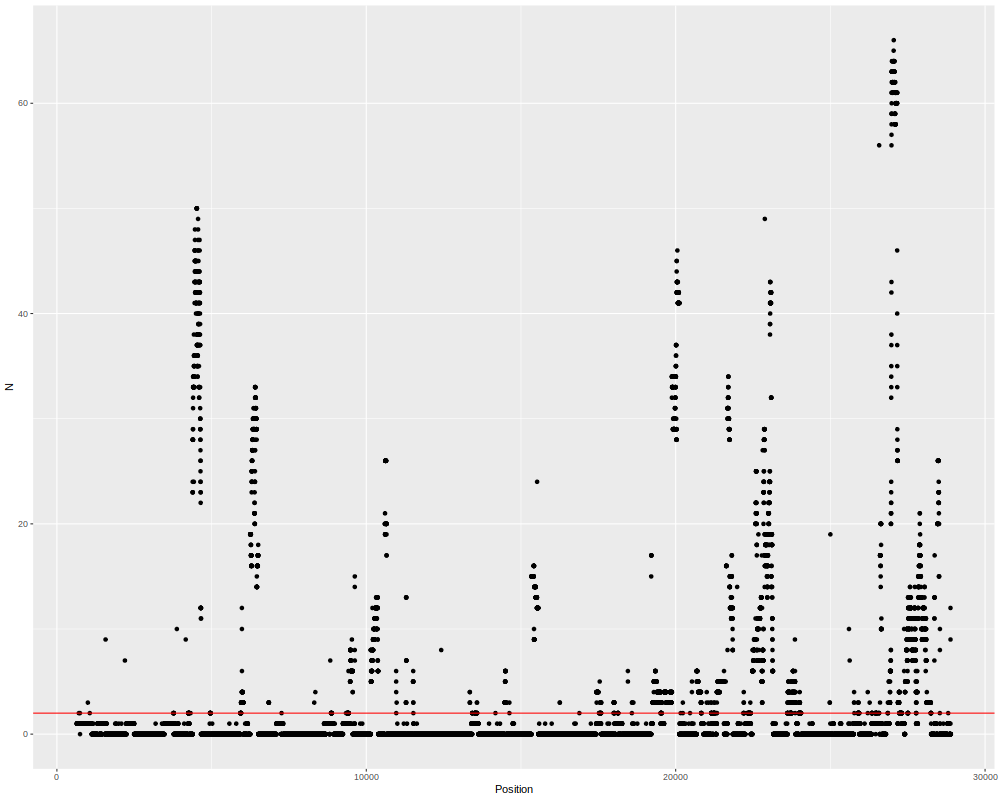

RObject{VecSxp}


In [17]:
print("Distributin of N across sequence")
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
pnas <- ggplot(data=dc_woterminalgaps) + geom_point(aes(x=Position,y=N)) + geom_hline(yintercept=maxNlimit,color="red")
pnas
"""

In [18]:
#print filter put columns based on the N threathhold
dc_woterminalgaps_woN = filter(:N => <=(maxNlimit) ,dc_woterminalgaps) # 
sub_alignment_columnwise!(aln,dc_woterminalgaps_woN.Position)
println("Size of the trimmed alignment aqfter removing terminal gappy columns and columns with more than $maxNlimit Ns ")
println(size(aln.M))
#sub_alignment!(aln,dc_woterminalgaps_woN.Position)

Size of the trimmed alignment aqfter removing terminal gappy columns and columns with more than 2.0 Ns 
(888, 23373)


In [19]:
println("writing down the kept columns to $columns_after_filter")
CSV.write(columns_after_filter, dc_woterminalgaps_woN[:,["Position"]],writeheader=false)


writing down the kept columns to /mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_kept_columns.txt


"/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_kept_columns.txt"

In [20]:
print("Test sequence with removed high N content columns")
dc2 = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)
dr2 = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)
@rput dc2 dr2
print("")

Doing transposition...


Done. Converting to a data frame...
Done


Doing transposition...
Done. Converting to a data frame...


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


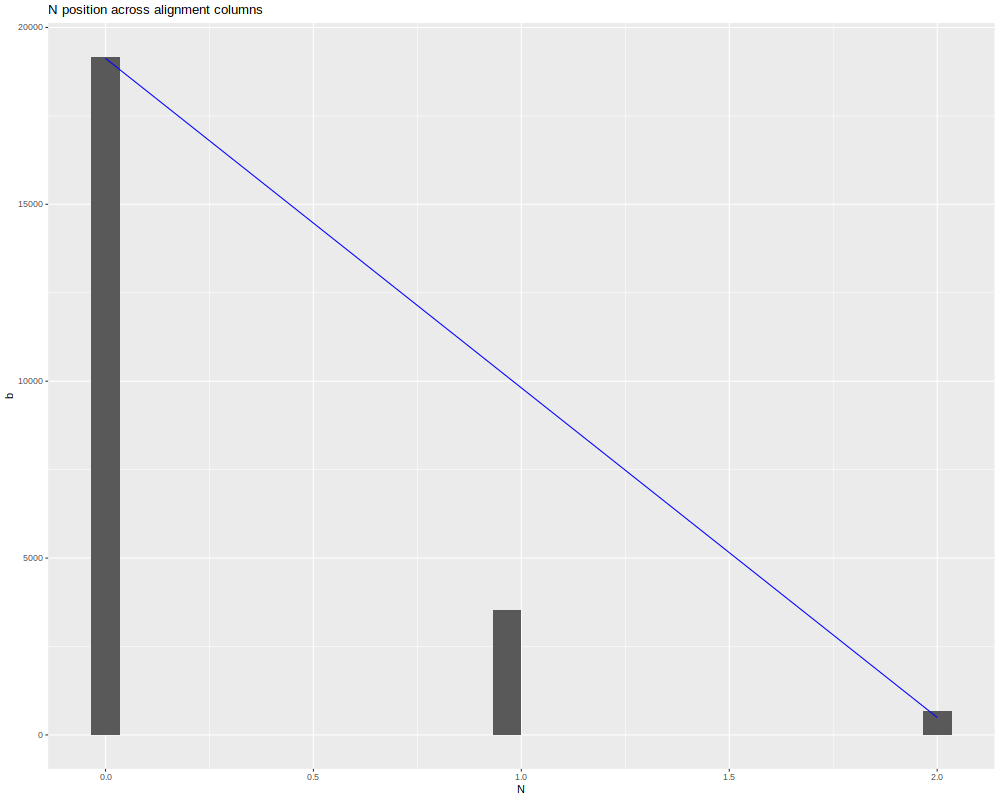

RObject{VecSxp}


In [21]:
R"""
df <- dc2
fit <- fitdist(df$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=df) + geom_histogram(aes(x=N))
xvals <- seq(0,max(df$N),2)
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(df)
df = data.table(a=xvals,b=fitD)
p <- p + geom_line(data = df, aes(a,b),color="blue") + ggtitle("N position across alignment columns")
p
"""
# xvals <- seq(0,max(df$N),2)
# fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(df)
# df = data.table(a=xvals,b=fitD)
# p <- p + geom_line(data = df, aes(a,b),color="blue") + ggtitle("N position across alignment columns")
# p
# """

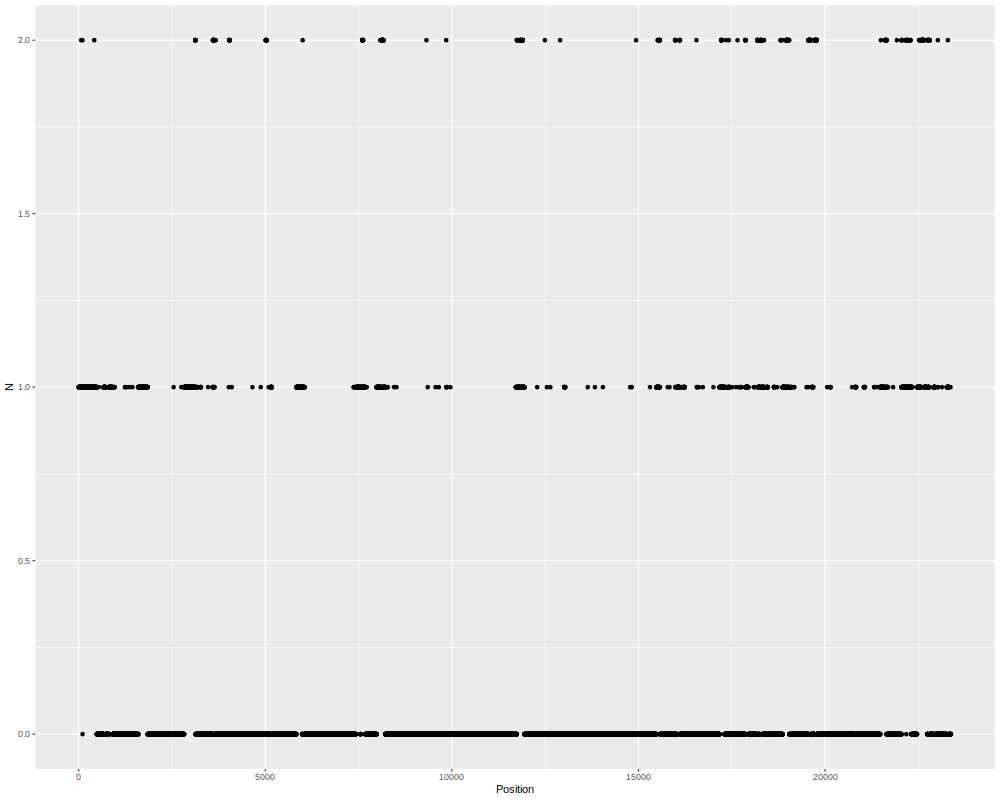

RObject{VecSxp}


In [22]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
p <- ggplot(data=dc2) + geom_point(aes(x=Position,y=N))
p
"""

┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


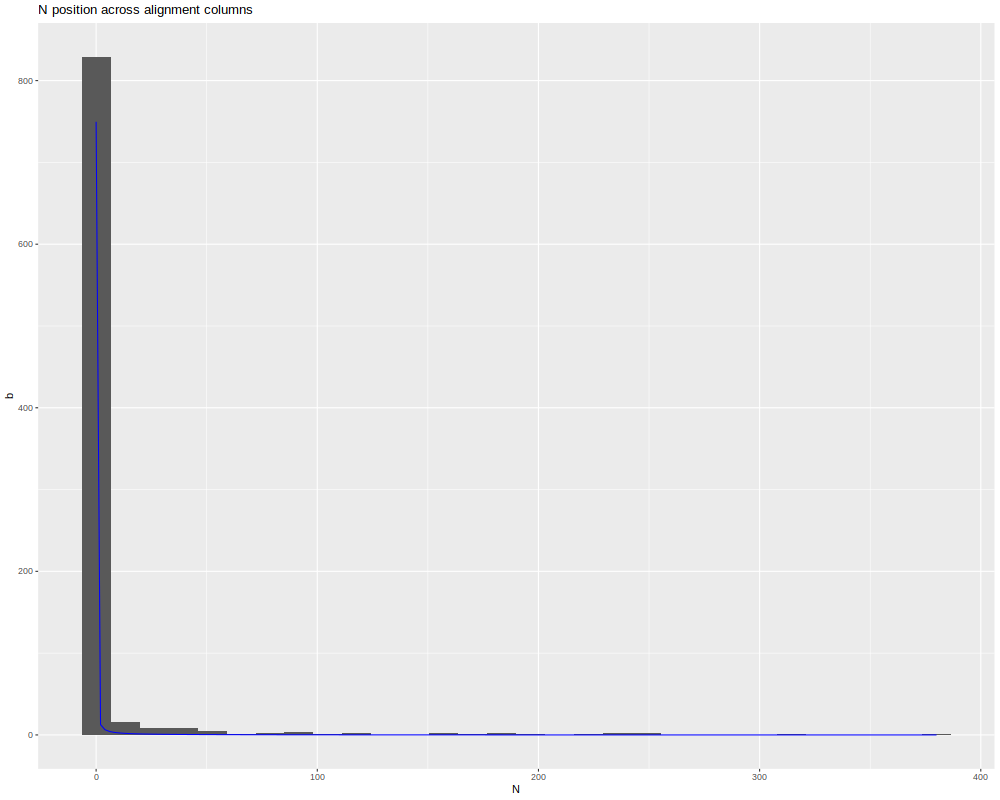

RObject{VecSxp}


In [23]:
R"""
df <- dr2
fit <- fitdist(df$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=df) + geom_histogram(aes(x=N))
xvals <- seq(0,max(df$N),2)
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(df)
df = data.table(a=xvals,b=fitD)
p <- p + geom_line(data = df, aes(a,b),color="blue") + ggtitle("N position across alignment columns")
p
"""

┌ Warning: RCall.jl: Warning: The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
│ ℹ Please use `after_stat(count)` instead.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


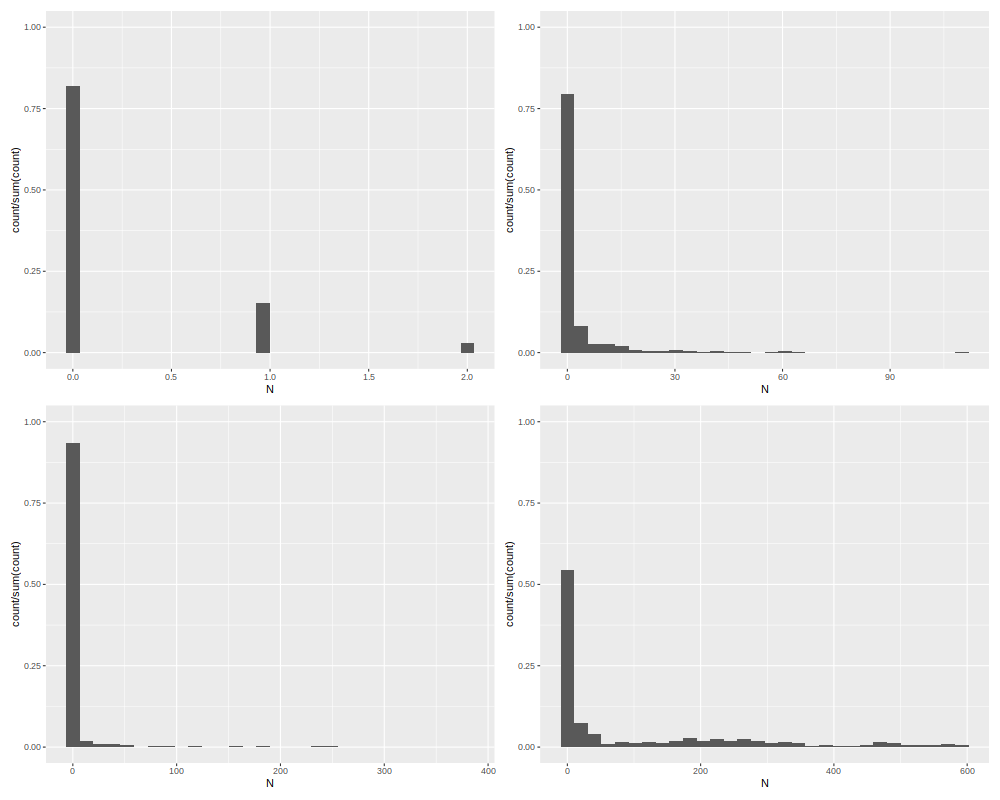

RObject{VecSxp}


In [24]:
@rput dc dc2 dr dr2
R"""
pini<-ggplot(dc, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)
p<-ggplot(dc2, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)

pinir<-ggplot(dr, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)
pr<-ggplot(dr2, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)

(p|pini)/(pr|pinir)
"""

In [25]:
dr2_N0 = filter(row -> row.N ==0, dr2)
print("Kept ",round(size(dr2_N0)[1]/size(dr2)[1],digits=2)," ",size(dr2_N0)[1])

Kept 0.84 747

In [26]:
#get the final set odf sequences
sub_alignment!(aln, dr2_N0.ID)
println(size(aln.M))
JuliaClusterAndTreeTools.write_to_fasta(aln, output_file_name)

(747, 23373)


0

In [27]:
CSV.write(rows_after_filter, dr2_N0[:,["ID"]],writeheader=false)

"/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_kept_rows.txt"

In [28]:
#remove the conservative columns
entropy_values_full, conservation_values_full = aln_conservation(aln)
refs = collect(join(aln.M[aln.name_sequence_map[reference_seq_id],:]))
#collect(join(aln.M[1,:]))

23373-element Vector{Char}:
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 ⋮
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'A': ASC

In [29]:
println("Final length: ",length(refs))
initial_length - length(blacklist_positions)
println("Initial length: ",initial_length)

Final length: 23373
Initial length: 29903


In [30]:
df_full_set = DataFrame(Reference=refs,ConsFull = conservation_values_full,EntropyFull = entropy_values_full,NRorg = dc_woterminalgaps_woN.Position, NR=1:length(refs))
size(df_full_set)

(23373, 5)

In [31]:
df_full_set.Rorg = map((x) -> reference_seq[x], df_full_set.NRorg)

23373-element Vector{Char}:
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 ⋮
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'A': ASC

In [32]:
df_full_set

Row,Reference,ConsFull,EntropyFull,NRorg,NR,Rorg
,Char,Float64,Float64,Int64,Int64,Char
1,G,1.0,0.0,645,1,G
2,T,1.0,0.0,646,2,T
3,A,1.0,0.0,647,3,A
4,A,1.0,0.0,648,4,A
5,T,1.0,0.0,649,5,T
6,A,1.0,0.0,650,6,A
7,A,1.0,0.0,651,7,A
8,A,1.0,0.0,652,8,A
9,G,1.0,0.0,653,9,G


In [33]:
refdf = DataFrame(Reference=collect(join(reference_seq)), NRorg = 1:length(reference_seq))
NRref = Array{Int64,1}()
ct = 0
for s in refdf.Reference
    s != '-' ? ct = ct + 1 : ""
    push!(NRref, ct)
end
refdf.NRref = NRref


29903-element Vector{Int64}:
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
     ⋮
 29724
 29724
 29724
 29724
 29724
 29724
 29724
 29724
 29724
 29724
 29724
 29724

In [34]:
out_full = leftjoin(df_full_set,refdf, on = [:Reference,:NRorg])
select(out_full, Not([:Rorg]) )

Row,Reference,ConsFull,EntropyFull,NRorg,NR,NRref
,Char,Float64,Float64,Int64,Int64,Int64?
1,G,1.0,0.0,645,1,595
2,T,1.0,0.0,646,2,596
3,A,1.0,0.0,647,3,597
4,A,1.0,0.0,648,4,598
5,T,1.0,0.0,649,5,599
6,A,1.0,0.0,650,6,600
7,A,1.0,0.0,651,7,601
8,A,1.0,0.0,652,8,602
9,G,1.0,0.0,653,9,603


In [35]:
country_ids = aln.names[map((x) -> occursin(country,x),aln.names)]

276-element Vector{String}:
 "England/ALDP-3C3EB7C/2022"
 "England/QEUH-3C5A530/2022"
 "England/ALDP-3C2902A/2022"
 "England/QEUH-3C5A8FB/2022"
 "England/PHEC-YYDUCS7/2022"
 "England/PHEP-YYRT8NQ/2022"
 "England/MILK-365C279/2022"
 "England/QEUH-3C827C0/2022"
 "England/LSPA-3C99CC7/2022"
 "England/LSPA-3C92B3A/2022"
 "England/LSPA-3C842FA/2022"
 "England/QEUH-3C88DB9/2022"
 "England/LSPA-3C7C046/2022"
 ⋮
 "England/QEUH-3C4E5B7/2022"
 "England/MILK-395051F/2022"
 "England/QEUH-3BDE40B/2022"
 "England/MILK-3875885/2022"
 "England/LSPA-3C6FD9A/2022"
 "England/QEUH-3C5CE06/2022"
 "England/LSPA-3C6C841/2022"
 "England/QEUH-3C7570C/2022"
 "England/ALDP-3BE4B1C/2022"
 "England/ALDP-3C3EA51/2022"
 "England/ALDP-3C3F4E9/2022"
 "England/LSPA-3C3D2B4/2022"

In [36]:
#get country aspecific
#sub_alignment!(aln, country_ids)

In [37]:
size(out_full)
entropy_values_country, conservation_values_country = aln_conservation(aln)



([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.014707755533002362, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.998661311914324, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [38]:
df_full_set.ConsCountry = conservation_values_country
df_full_set.EntropyCountry = entropy_values_country

23373-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.014707755533002362
 0.02673554599486592
 ⋮
 0.0
 0.02673554599486592
 0.014707755533002362
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [39]:
df_full_set.Reference = map( (x) -> string(x), df_full_set.Reference )
df_full_set.Rorg = map( (x) -> string(x), df_full_set.Rorg )
#select!(df_full_set, Not([:Rorg]))
CSV.write(conservation_data,df_full_set)

"/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_data.csv"

┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


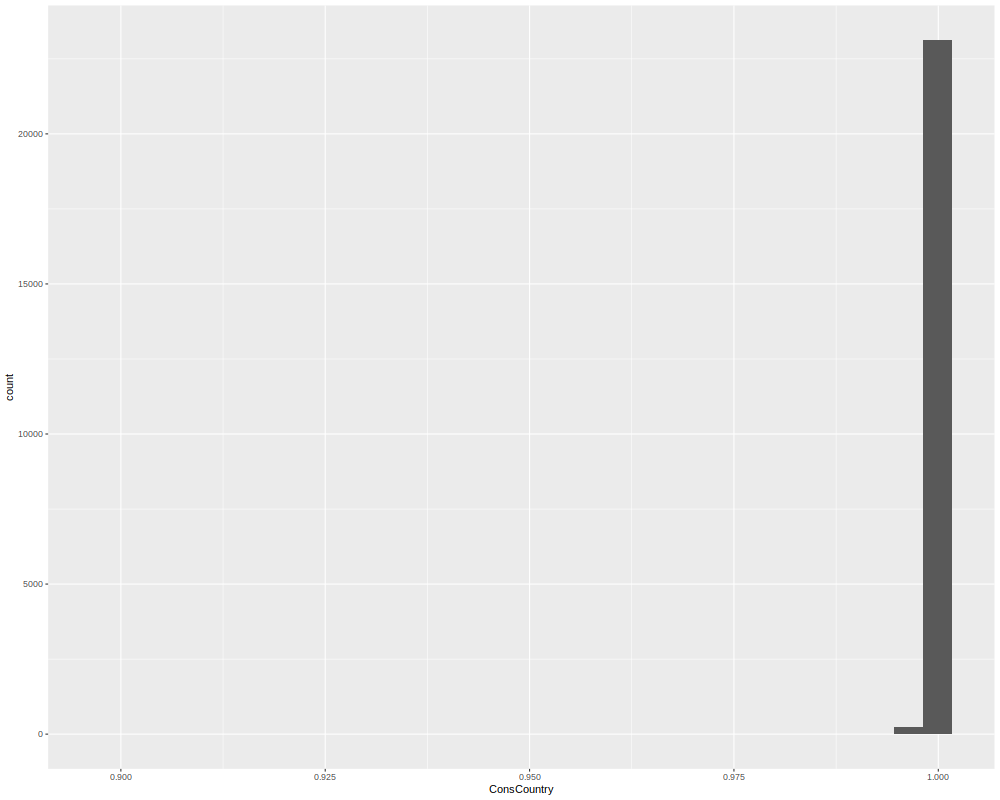

RObject{VecSxp}


In [40]:
@rput df_full_set
R"""
ggplot(data = df_full_set) +
geom_histogram(aes(x=ConsCountry))
"""

In [41]:
size(aln.M)
df_full_set
#spit out only non conservative columns
pos_non_cons = df_full_set.NR[df_full_set.EntropyFull .> 0]
sub_alignment_columnwise!(aln, pos_non_cons)
println(size(aln.M))
JuliaClusterAndTreeTools.write_to_fasta(aln, output_file_nonconspoz_name)

(747, 1097)


0